In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


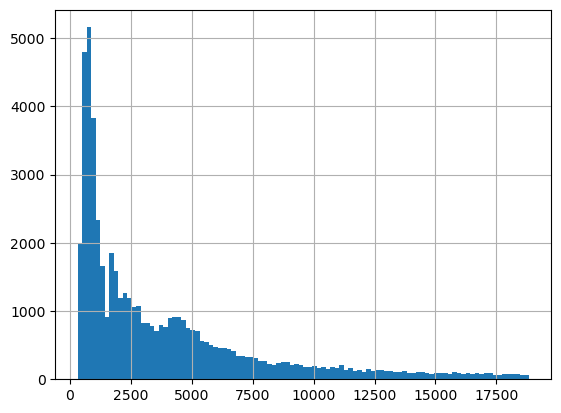

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
y_pred = reg.predict(X_test)

In [13]:
score = r2_score(y_pred, y_test)
score

0.8977468673125747

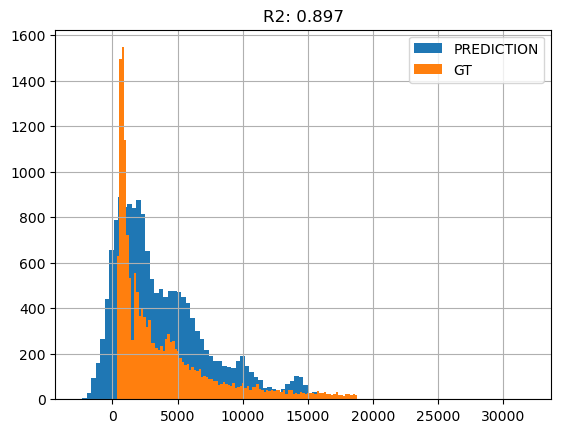

In [14]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [21]:
class LeakyReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X.copy()
        return np.where(X>0, X, 0.01*X)
    
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, dLdy):
        return dLdy * np.where(self.X>0, 1, 0.01)
    
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        y = np.clip(1 / (1 + np.exp(-X)), 0.1, 0.9)
        self.y = y.copy()
        return y
    
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, dLdy):
        return dLdy * self.y * (1 - self.y)
        
class Linear:
    def __init__(self, input_size, output_size, act='leakyrelu'):
        self.input_size = input_size
        self.output_size = output_size
        self.act = (LeakyReLU() if act=='leakyrelu' else Sigmoid())
        self.W = np.random.randn(self.input_size, self.output_size)/np.sqrt(self.input_size)
        self.b = np.zeros(self.output_size)
    
    def forward(self, X):
        self.X = X.copy()
        return self.act(X@self.W + self.b)
    
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, dLdy, lr, l2=0):
        dLdy = self.act.backward(dLdy)
        self.W -= lr * ((self.X.T @ dLdy) / dLdy.shape[0]) + l2 * self.W
        self.b -= lr * (dLdy.mean(axis=0)) + l2 * self.b
        # self.W = np.clip(self.W, -1e1, 1e1)
        # self.b = np.clip(self.b, -1e1, 1e1)
        return dLdy @ self.W.T / self.W.shape[1]
    
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(9,),
        learning_rate=0.001,
        max_iter=10,
        activation='leakyrelu',
        l2=0
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.lr = learning_rate
        self.max_iter = max_iter
        self.main = [Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i+1], act=activation) for i in range(len(self.hidden_layer_sizes)-1)]\
                  + [Linear(self.hidden_layer_sizes[-1], 1, act=activation)]
        self.l2 = l2
    
    def train(self, X, y, batch_size=-1):
        tq = tqdm(range(self.max_iter))
        losses_train, losses_test = [], []
        if(batch_size<0): batch_size = X.shape[0]
        for i in tq:
            for start in range(0, X.shape[0], batch_size):
                y_ = self.predict(X[start:start+batch_size])
                l = self.loss(y[start:start+batch_size], y_) 
                # losses_train.append(l)
                # tq.set_postfix({'loss':l[0], 'mean':np.mean(losses_train[-X.shape[0]//batch_size:])})
                self.backward()
            losses_test.append(self.loss(self.predict(X_test), y_test)[0])
            tq.set_postfix({'loss':losses_test[-1]})
            if(len(losses_test)>3 and losses_test[-1] > max(losses_test[-4:-1])): break
    
    def predict(self, X):
        for l in self.main:
            X = l(X)
        return X
    
    def loss(self, y_true, y_pred):
        self.y_diff = (y_pred - y_true).reshape(-1,1).copy()
        return np.square(y_pred - y_true).mean(axis=0)
    
    def backward(self):
        n = len(self.hidden_layer_sizes)
        loss = self.y_diff / self.y_diff.shape[0]
        # loss = np.where(self.y_diff>0, 1, -1).reshape(-1,1)
        for i in range(n):
            loss = self.main[n-1-i].backward(loss, self.lr, self.l2)

# Проверяем модель MLP на выборке Diamonds

In [22]:
model = MLPRegressor(hidden_layer_sizes = (9, 108, 108, 108), learning_rate=0.001, max_iter=1000, activation='leakyrelu', l2=0)
model.train(X_train, y_train, batch_size=1000)
y_pred = model.predict(X_test)
score = r2_score(y_pred, y_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

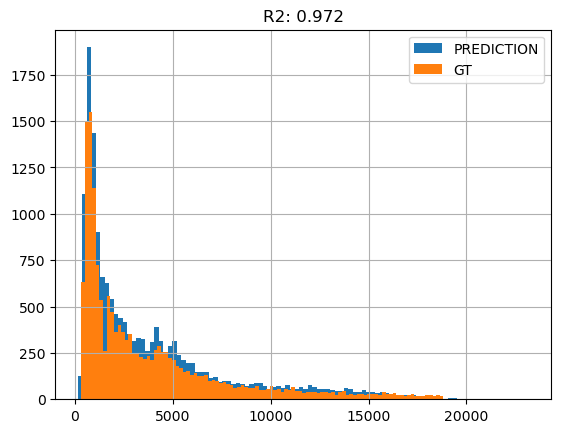

In [23]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();